# **Sentiment Analysis with LSTM on PyTorch**

[![Python](https://img.shields.io/badge/Python-3.9%2B-blue?style=flat&logo=python&logoColor=white)](https://www.python.org/)
[![PyTorch](https://img.shields.io/badge/PyTorch-2.0%2B-red?style=flat&logo=pytorch&logoColor=white)](https://pytorch.org/)
[![RNN](https://img.shields.io/badge/Model-RNN%20(LSTM)-green?style=flat)](https://en.wikipedia.org/wiki/Recurrent_neural_network)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mobadara/imdb-movie-review-sentiment-analysis/blob/main/notebooks/model-training.ipynb)

---

## **End-to-End Sentiment Analysis with PyTorch LSTM**

This project demonstrates an end-to-end sentiment analysis solution built using PyTorch, focusing on a binary classification problem (positive vs. negative sentiment). The primary objective of this submission is to showcase proficiency in key deep learning concepts and practical PyTorch implementation skills, including:

* **Data Handling with Pandas and PyTorch:** Efficiently loading, processing, and transforming data from a Pandas DataFrame into PyTorch `TensorDataset` and `DataLoader` for effective batch processing.
* **Comprehensive Text Preprocessing:** Implementing robust text cleaning techniques, including HTML tag removal, lowercasing, tokenization, stop word removal, and lemmatization, crucial for preparing raw text for neural network input.
* **Vocabulary Management and Embedding Preparation:** Building a custom vocabulary and converting textual data into numerical sequences suitable for embedding layers. This includes handling padding and unknown tokens.
* **Recurrent Neural Network (RNN) Architecture Design:** Constructing and training a Long Short-Term Memory (LSTM) network, a powerful variant of RNNs, specifically tailored for sequential data like natural language. The model will leverage an embedding layer for dense word representations.
* **PyTorch Model Training and Evaluation:** Implementing a complete training loop, defining appropriate loss functions (Binary Cross-Entropy), optimizers (Adam), and evaluating model performance (accuracy) on a held-out test set.

The [dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) for this task consists of reviews with a perfectly balanced class distribution, providing an ideal scenario for training and validating a sentiment classifier. This notebook serves as a comprehensive demonstration of the entire machine learning pipeline, from raw data to a trained predictive model, using the PyTorch framework.

---

## **Theoretical Background: Recurrent Neural Networks (RNNs)**

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to recognize patterns in sequences of data, such as text, speech, or time series. Unlike traditional feedforward neural networks, RNNs have connections that allow information to flow in a loop, enabling them to maintain an internal state (or "memory") that captures information about previous elements in the sequence. This "memory" makes them particularly well-suited for tasks involving sequential data where the context of past elements is crucial for understanding the current one.

### **Introduction: The Challenge of Vanishing/Exploding Gradients**

A significant challenge with vanilla RNNs is the problem of **vanishing or exploding gradients**. During backpropagation through time (BPTT), which is how RNNs learn, gradients can either become extremely small (vanishing) or extremely large (exploding) as they propagate through many time steps.

* **Vanishing gradients** make it difficult for the network to learn long-range dependencies, as the influence of earlier inputs on the current output diminishes over time.
* **Exploding gradients** lead to unstable training and large weight updates, potentially causing the model to diverge.

### **Long Short-Term Memory (LSTM) Networks**

To address the vanishing gradient problem, **Long Short-Term Memory (LSTM) networks** were introduced. LSTMs are a special type of RNN that are capable of learning long-term dependencies. They achieve this through a sophisticated internal structure called a "cell state" and several "gates" that regulate the flow of information into and out of the cell state.

Each LSTM unit consists of:
* **Forget Gate:** Decides what information to throw away from the cell state.
* **Input Gate:** Decides what new information to store in the cell state.
* **Output Gate:** Decides what part of the cell state to output.

These gates are typically composed of a sigmoid neural net layer and a pointwise multiplication operation. The sigmoid layer outputs numbers between 0 and 1, describing how much of each component should be let through. A value of 0 means "don't let anything through," while a value of 1 means "let everything through."

By intelligently controlling the flow of information, LSTMs can preserve relevant information over long sequences, making them highly effective for tasks like sentiment analysis, machine translation, and speech recognition.

## **Setup and Library Initialization**
This section is dedicated to the essential setup procedures required for the project. Below, we'll load all necessary Python packages, ensuring the environment is correctly configured with the appropriate settings and dependencies. This foundational step is critical for seamless execution of the subsequent data processing, model training, and evaluation phases of our sentiment analysis task.

In [1]:
# import packages
import os
import torch
import nltk
import re
import kagglehub
import matplotlib
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm

# Download necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

plt.style.use('ggplot')
torch.manual_seed(42)

# Download latest version Dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)
print(f'The path {path} exists: {os.path.exists(path)}')
print(f'Files in the path {path}: {os.listdir(path)}')

print(f'-'*50)
print(f'PyTorch version: {torch.__version__}')
print(f'NLTK version: {nltk.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print('Setup Completed . . . ')

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
The path /kaggle/input/imdb-dataset-of-50k-movie-reviews exists: True
Files in the path /kaggle/input/imdb-dataset-of-50k-movie-reviews: ['IMDB Dataset.csv']
--------------------------------------------------
PyTorch version: 2.6.0+cu124
NLTK version: 3.9.1
Pandas version: 2.2.3
Matplotlib version: 3.7.2
Setup Completed . . . 


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Data Loading**

In this crucial step, we will load our dataset, which has been pre-downloaded and stored within the specified directory. The file path to this dataset is dynamically managed and accessible via the `path` variable, ensuring flexibility and ease of access. We will utilize the `pandas` library to efficiently read the data into a DataFrame, providing a robust structure for subsequent preprocessing and analysis. This initial data ingestion is fundamental to preparing our text reviews for the sentiment analysis pipeline.

In [3]:
try:
    # Load the data from the specified path into a Pandas DataFrame
    full_path = os.path.join(path, 'IMDB Dataset.csv')
    df = pd.read_csv(full_path)
    print(f"Successfully loaded data from: {full_path}")
    print("DataFrame Head:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()
except FileNotFoundError:
    print(f"Error: The file '{full_path}' was not found.")
    print("Please ensure the file exists at the specified path.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Successfully loaded data from: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
DataFrame Head:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


This dataset comprises **50,000** reviews, each accompanied by a sentiment label indicating whether the review is positive or negative.

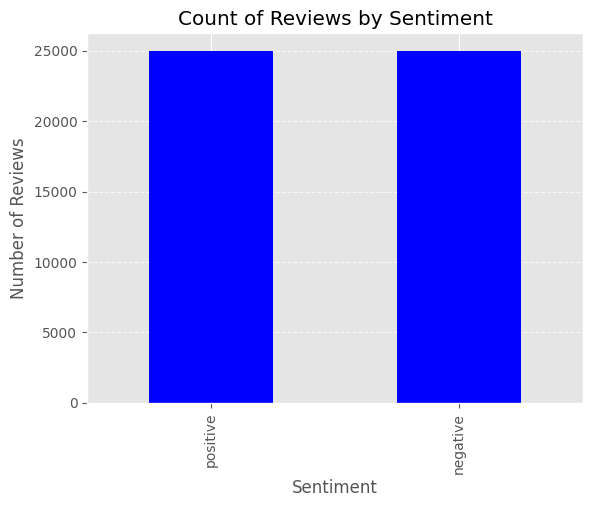

In [4]:
ax = df.sentiment.value_counts().plot(kind='bar', color='blue', title='Count of Reviews by Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### **Observation on Class Balance**

As visually confirmed by the bar chart above, the dataset exhibits a perfectly balanced class distribution between positive and negative sentiments. This crucial characteristic implies that both sentiment classes are equally represented, mitigating common challenges associated with imbalanced datasets such as model bias towards the majority class. This balanced nature will facilitate straightforward training without the immediate need for advanced sampling techniques (e.g., oversampling, undersampling) or specialized loss functions, contributing to a more robust and fair evaluation of our sentiment analysis model.

In [5]:
reviews = df['review'].tolist()
sentiments = df['sentiment'].tolist()

# **Data Preprocessing**

The `preprocess_text` function, shown below, is designed to clean up the raw movie reviews and get them ready for the model. This is a crucial step because it takes messy text and makes it consistent, while keeping important parts like emoticons.

Let's break down what each part of this function does:

- **Remove HTML Tags**: First, it gets rid of any HTML tags (like `<br/>` or `<i>`). These tags are just formatting and don't tell us anything about the sentiment.

- **Lowercase Everything**: All text is converted to lowercase. This means words like "Good," "good," and "GOOD" are treated the same, which helps keep the vocabulary smaller and more consistent.

- **Grab and Keep Emoticons**: This is a special part of the function. It finds emoticons (like `:)` or `:D`) and saves them. Emoticons are super important for sentiment, so we make sure they stick around even after we clean up other punctuation.

- **Clean Up Other Characters**: After saving the emoticons, the function removes most other non-letter characters (like numbers or extra spaces) and replaces them with a single space. This further tidies up the text.

- **Break into Words (Tokenize)**: The cleaned text is then split into individual words or "tokens." This turns a big block of text into a list of words, which is what our model needs.

- **Remove Stop Words**: Common words that don't add much meaning to the sentiment (like "the," "is," "and") are taken out. This helps the model focus on the more important words.

- **Get Root Words (Lemmatize)**: Finally, words are changed to their basic form. For example, "running," "runs," and "ran" all become "run." This helps reduce the total number of unique words while keeping their core meaning.

In [6]:
def preprocess_text(text: str) -> None:
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Convert to lowercase
    text = text.lower()
    # Extract emoticons characters
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Convert words to their root form (stemmilng)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

Now that our `preprocess_text` function is defined, it's time to apply it to all the movie reviews we loaded. This step transforms our raw text into a clean, tokenized format that our model can understand. Right after that, we'll convert our "positive" and "negative" sentiment labels into numbers, which is essential for PyTorch.

In [7]:
# Apply preprocessing to your reviews
preprocessed_reviews = [preprocess_text(review) for review in reviews]

# Convert sentiments to numerical labels
sentiment_labels = [1 if sentiment == 'positive' else 0 for sentiment in sentiments]


### **Splitting Data into Training and Testing Sets**

With our reviews preprocessed and sentiments converted to numerical labels, the next crucial step is to divide our dataset into distinct training and testing sets. This separation is fundamental in machine learning to ensure that we can evaluate our model's performance on unseen data, providing an honest assessment of its generalization capabilities.

We'll use `sklearn.model_selection.train_test_split` for this task.

In [8]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(preprocessed_reviews,
                                                                sentiment_labels, test_size=0.2, random_state=42)

### **Building the Vocabulary and Word-to-Index Mapping**

Now that our data is split, the next step is to create a vocabulary from our training reviews. This vocabulary will essentially be a unique list of every word our model has seen during training. Once we have this list, we'll assign a unique numerical ID (an index) to each word. This numerical representation is crucial because neural networks, including LSTMs, can only process numbers, not raw text.

We'll also add special tokens for padding and unknown words, which are essential for consistent input to our model.

In [9]:
vocab = set(word for review in train_reviews for word in review)
word_to_index = {word: index + 2 for index, word in enumerate(vocab)}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

### **Converting Reviews to Numerical Sequences**

Now that we have our word_to_index mapping, we can finally convert our text reviews into numerical sequences. This is the stage where words transform into numbers, a format that our PyTorch **LSTM model** can actually process. We'll do this for both our training and testing reviews.

In [10]:
train_sequences = [[word_to_index.get(word, word_to_index['<UNK>']) for word in review] for review in train_reviews]
test_sequences = [[word_to_index.get(word, word_to_index['<UNK>']) for word in review] for review in test_reviews]


### **Padding Sequences to Uniform Length**

Deep learning models, especially those operating on batches of data like LSTMs, require all input sequences within a batch to have the same fixed length. Since our movie reviews vary in length, we need to apply padding. This process involves extending shorter sequences with a special "padding" token until they match the length of the longest sequence in our training set.

In [11]:
max_length = max(len(seq) for seq in train_sequences)
train_sequences = [seq + [word_to_index['<PAD>']] * (max_length - len(seq)) for seq in train_sequences]
test_sequences = [seq + [word_to_index['<PAD>']] * (max_length - len(seq)) for seq in test_sequences]


### **Converting Data to PyTorch Tensors**
The final step in preparing our data is to convert our numerical Python lists into PyTorch tensors. Tensors are the fundamental data structures in PyTorch, similar to NumPy arrays, but with the added capability of being used on GPUs for accelerated computation, which is essential for training deep learning models.

In [12]:
train_sequences = torch.tensor(train_sequences)
train_labels = torch.tensor(train_labels)
test_sequences = torch.tensor(test_sequences)
test_labels = torch.tensor(test_labels)


## **Defining the LSTM Model Architecture**

This section defines the neural network architecture for our sentiment analysis task. We're using a Long Short-Term Memory (LSTM) network, which is particularly well-suited for processing sequential data like text. The model is encapsulated within the SentimentAnalysisLSTM class, inheriting from PyTorch's `nn.Module`.

In [13]:
# Define the LSTM Model
class SentimentAnalysisLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int, n_layers: int, bidirectional: bool, dropout: float) -> None:
        """
        Initializes the SentimentAnalysisLSTM model.

        Args:
            vocab_size (int): The number of unique words in the vocabulary.
            embedding_dim (int): The size of the word embeddings.
            hidden_dim (int): The number of features in the hidden state of the LSTM.
            output_dim (int): The size of the output layer (1 for binary classification).
            n_layers (int): The number of LSTM layers.
            bidirectional (bool): If True, the LSTM will be bidirectional.
            dropout (float): The dropout probability for regularization.
        """
        super(SentimentAnalysisLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            text (torch.Tensor): The input text data.

        Returns:
            torch.Tensor: The output of the model.
        """
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.lstm.bidirectional else hidden[-1, :, :]
        return self.sigmoid(self.fc(hidden))

**Explanation of Components**

1. **`nn.Embedding Layer`**:
This is the first layer, responsible for taking our numerical word indices and converting them into dense, continuous vectors (embeddings). Each word in our vocabulary will have its own learned vector representation, capturing semantic relationships between words.

2. **`nn.LSTM Layer`**:
This is the core of our recurrent network. It takes the word embeddings as input.

- **`hidden_dim`**: Determines the dimensionality of the `hidden state`, which acts as the "memory" of the LSTM.

- **`num_layers`**: Allows stacking multiple LSTM layers on top of each other, enabling the model to learn more complex patterns.

- **`bidirectional`**: A crucial parameter that enables the LSTM to process the input sequence in both forward and backward directions. This means the model can capture context from words appearing both before and after the current word in a sentence, which is highly beneficial for understanding sentiment.

- **`dropout`**: A regularization technique applied to the output of each LSTM layer to prevent overfitting by randomly setting a fraction of outputs to zero during training.

- **`batch_first=True`**: This setting is convenient because it means our input tensors will be shaped (`batch_size`, `sequence_length`, `embedding_dim`), which aligns well with common data loading patterns.

3. **`nn.Linear`** (Fully Connected) Layer:
After the LSTM processes the entire sequence, we are interested in its final representation. For sentiment classification, we typically take the final hidden state(s) of the LSTM. This linear layer takes that final hidden state and transforms it into our desired output_dim (which is 1 for binary classification). If the LSTM is bidirectional, the hidden state from both directions are concatenated, doubling its size, which is accounted for in the hidden_dim * 2 calculation.

4. **`nn.Sigmoid`** Activation Function:
Since this is a binary classification problem (positive or negative), we use a sigmoid function on the output of the final linear layer. The sigmoid function squashes the output value into a range between 0 and 1, which can then be interpreted as the probability of the review being positive.

Forward Pass (`forward` method):
The forward method defines the flow of data through the network:

1. Embeddings: The input text (a batch of numerical sequences) first goes through the embedding layer, turning word indices into dense vectors.

2. LSTM Processing: These embeddings are then fed into the lstm layer. The LSTM processes the sequence, maintaining an internal "memory" and producing an output (the output of all time steps) and the final hidden and cell states.

3. Extract Final Hidden State: For sequence classification tasks like sentiment analysis, we typically use the final hidden state of the LSTM as the aggregated representation of the entire sequence.

- If the LSTM is bidirectional, the `hidden` tensor contains states for both forward and backward directions across all layers. We specifically take the final hidden states from the last forward layer (`hidden[-2, :, :]`) and the last backward layer (`hidden[-1, :, :]`) and concatenate them to form a single, richer representation.

- If unidirectional, we simply take the hidden state from the last layer (`hidden[-1, :, :]`).

- Final Prediction: This combined (or single) final hidden state is then passed through the `fc` (fully connected) layer, and a `sigmoid` activation is applied to produce the final sentiment probability for each review in the batch.

# **Training the Sentiment Analysis LSTM Model**

This section details the training and validation process for our SentimentAnalysisLSTM model. It includes the setup for splitting data into train and validation sets, defining hyperparameters, initializing the model components, executing the training loop, and comprehensive evaluation with key metrics and visualizations.

### **Hyperparameter Configuration**
Core hyperparameters such as `vocab_size`, `embedding_dim`, `hidden_dim`, `n_layers`, `bidirectional`, `dropout`, `learning_rate`, `batch_size`, and `epochs` are defined. These parameters are crucial for controlling the model's architecture and the learning process.

In [14]:
# Hyperparameters
vocab_size = len(word_to_index)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.5
learning_rate = 0.01
batch_size = 64
num_epochs = 8

## **Data Preparation for Training, Validation, and Testing**

The `train_sequences` and `train_labels` are further partitioned into distinct training (80%) and validation (20%) sets. This separation is vital for monitoring model performance on unseen data during training, helping to detect overfitting. `TensorDataset` and `DataLoader` are used to efficiently manage and batch the data for all three sets (training, validation, and the final test set).

In [15]:
train_sequences_split, val_sequences, train_labels_split, val_labels = train_test_split(
    train_sequences, train_labels, test_size=0.2, random_state=42
)

In [16]:
train_dataset = TensorDataset(train_sequences_split, train_labels_split)
val_dataset = TensorDataset(val_sequences, val_labels)
test_dataset = TensorDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **Model, Loss Function, and Optimizer Initialization**
An instance of the `SentimentAnalysisLSTM` model is created with the specified hyperparameters and moved to the chosen device. `nn.BCELoss()` (Binary Cross-Entropy Loss) is selected as the criterion for measuring the difference between predicted probabilities and true binary labels, suitable for binary classification. The optim.Adam optimizer is employed to update model weights based on calculated gradients, with a defined learning_rate.

In [17]:
model = SentimentAnalysisLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []

MODEL_SAVE_DIR = 'models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

### **Training and Validation Loop**

The training process iterates over a fixed number of `epochs`. Each epoch comprises two phases:

1. **Training Phase (`model.train()`)**:

- The model is set to training mode, enabling dropout.
- For each mini-batch from the `train_loader`:
 - Input sequences and labels are moved to the device.
 - Previous gradients are cleared (`optimizer.zero_grad()`).
 - Predictions are generated.
 - The loss is calculated, and backpropagation (`loss.backward()`) computes gradients.
 - Optimizer updates model parameters (`optimizer.step()`).
- Training loss and predicted labels are accumulated to calculate epoch-level training accuracy.

2. **Validation Phase (`model.eval()`)**:

- The model is switched to evaluation mode, disabling training-specific layers like dropout.
- `torch.no_grad()` is activated to prevent gradient computations, optimizing performance for inference.
- For each mini-batch from the val_loader:
 - Predictions are made, and loss is computed.
 - Validation loss, predicted labels, and true labels are accumulated.
- At the end of the validation phase, Validation Accuracy, Precision, and Recall are calculated using sklearn.metrics. These metrics provide a comprehensive view of the model's performance on the validation set, especially regarding its ability to correctly identify positive instances (Precision) and its coverage of all actual positive instances (Recall).
- Progress is printed for each epoch, showing training and validation loss, accuracy, precision, and recall.
- The state of the model at the end of each epoch is saved for reference.

In [19]:
print('\nStarting training...')
for epoch in tqdm(range(num_epochs), desc=f'Training . . . '):
    # Training phase
    model.train()
    running_loss = 0.0
    all_train_predictions = []
    all_train_labels = []

    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(sequences).squeeze(1)
        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        all_train_predictions.extend(torch.round(predictions).detach().cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)


    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_val_predictions = []
    all_val_labels = []
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            predictions = model(sequences).squeeze(1)
            loss = criterion(predictions, labels.float())

            val_running_loss += loss.item() * labels.size(0)
            all_val_predictions.extend(torch.round(predictions).cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_accuracy = accuracy_score(all_val_labels, all_val_predictions)
    epoch_val_precision = precision_score(all_val_labels, all_val_predictions, zero_division=0)
    epoch_val_recall = recall_score(all_val_labels, all_val_predictions, zero_division=0)

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    val_precisions.append(epoch_val_precision)
    val_recalls.append(epoch_val_recall)

    print(f'Epoch {epoch+1}/{num_epochs} | '
          f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.4f} | '
          f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f} | '
          f'Val Prec: {epoch_val_precision:.4f} | Val Rec: {epoch_val_recall:.4f}')

    # Save Model After Each Epoch
    model_path = os.path.join(MODEL_SAVE_DIR, f'sentiment-lstm-epoch-{epoch+1}.pt')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

print('\nTraining complete.')


Starting training...


Training . . . :   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/8 | Train Loss: 0.6785 | Train Acc: 0.5637 | Val Loss: 0.6106 | Val Acc: 0.6789 | Val Prec: 0.6773 | Val Rec: 0.6956
Model saved to models/sentiment-lstm-epoch-1.pt
Epoch 2/8 | Train Loss: 0.5369 | Train Acc: 0.7334 | Val Loss: 0.4811 | Val Acc: 0.7741 | Val Prec: 0.7361 | Val Rec: 0.8619
Model saved to models/sentiment-lstm-epoch-2.pt
Epoch 3/8 | Train Loss: 0.4253 | Train Acc: 0.8070 | Val Loss: 0.4477 | Val Acc: 0.7975 | Val Prec: 0.8578 | Val Rec: 0.7181
Model saved to models/sentiment-lstm-epoch-3.pt
Epoch 4/8 | Train Loss: 0.3708 | Train Acc: 0.8391 | Val Loss: 0.4192 | Val Acc: 0.8206 | Val Prec: 0.8321 | Val Rec: 0.8080
Model saved to models/sentiment-lstm-epoch-4.pt
Epoch 5/8 | Train Loss: 0.3238 | Train Acc: 0.8641 | Val Loss: 0.4171 | Val Acc: 0.8155 | Val Prec: 0.7908 | Val Rec: 0.8632
Model saved to models/sentiment-lstm-epoch-5.pt
Epoch 6/8 | Train Loss: 0.2965 | Train Acc: 0.8778 | Val Loss: 0.4187 | Val Acc: 0.8249 | Val Prec: 0.8657 | Val Rec: 0.7733
Model save

### **Plotting Training History**

Now that  the training loop have concluded, `matplotlib` is used to visualize the model's learning trajectory. Three plots are generated:

- **Loss Curve**: Illustrates the training and validation loss over epochs.'

- **Accuracy Curve**: Shows the training and validation accuracy over epochs.

- **Validation Precision and Recall Curve**: Tracks the validation precision and recall values over epochs, allowing for observation of their trends throughout training.

These plots are critical for diagnosing issues such as overfitting (where validation loss increases or accuracy/precision/recall plateaus/decreases while training metrics continue to improve).


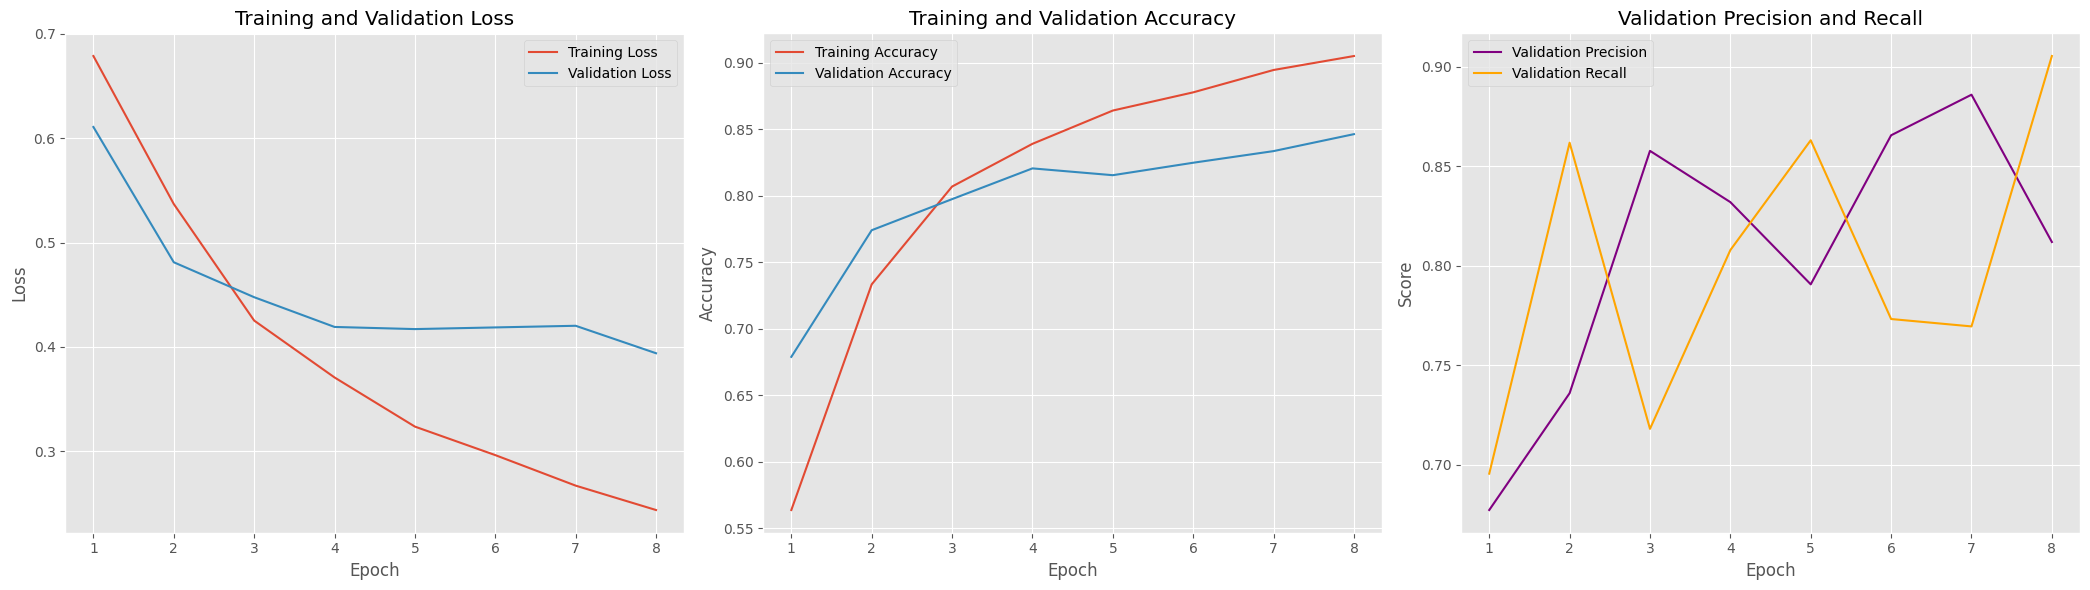

In [22]:
# Plot Results
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(21, 6)) # Increased figure size for 3 plots

# Plotting Loss
plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy
plt.subplot(1, 3, 2) # Changed to 1 row, 3 columns
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting Precision and Recall
plt.subplot(1, 3, 3) # New subplot
plt.plot(epochs_range, val_precisions, label='Validation Precision', color='purple')
plt.plot(epochs_range, val_recalls, label='Validation Recall', color='orange')
plt.title('Validation Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Training Observations and Performance Analysis**

During the training process, key metrics including training loss, validation loss, training accuracy, and validation accuracy were closely monitored to assess the model's learning progression and generalization capabilities.

- Epoch 1-3: Optimal Learning Phase
  
     The model demonstrated robust learning in the initial epochs. A critical observation was made at Epoch 3, where the model achieved its most balanced performance between the training and validation sets. At this point:

    - Training Accuracy: 80.7%
    - Validation Accuracy: 79.75%
    - Training Loss: 0.425
    - Validation Loss: 0.447
  
The close proximity of the training and validation metrics at Epoch 3 indicates strong generalization and minimal overfitting, suggesting that this epoch represents an optimal state of the model's learned representations before potential memorization of the training data.

- Epoch 4-8: Signs of Overfitting

    After Epoch 3, the model began to exhibit traces of overfitting. While not explicitly detailed in terms of exact values, this typically implies that the training accuracy continued to improve or remained high, while the validation accuracy either plateaued or began to subtly decline, and the gap between training and validation loss widened. This behavior is characteristic of the model learning noise or specific patterns in the training data that do not generalize well to unseen examples.

### **Final Evaluation on Test Set**
To provide an unbiased assessment of the model's generalization capability, a final evaluation is performed on the completely unseen test_dataset. The model remains in `eval()` mode, and predictions are gathered. The Final Test Accuracy, Precision, and Recall are calculated and printed, offering a robust measure of the model's expected performance on new, real-world data.

The `zero_division=0` parameter in `precision_score` and `recall_score` is used to handle potential scenarios where there might be no true positive or predicted positive samples, preventing division-by-zero errors and returning a score of 0 in such cases.










In [23]:
# Final Evaluation on Test Set
print('\nEvaluating on test set\n...')
model.eval()
all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        predictions = model(sequences).squeeze(1)
        predicted = torch.round(predictions)
        all_test_predictions.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
test_precision = precision_score(all_test_labels, all_test_predictions, zero_division=0)
test_recall = recall_score(all_test_labels, all_test_predictions, zero_division=0)

print(f'Final Test Accuracy: {test_accuracy:.4f}')
print(f'Final Test Precision: {test_precision:.4f}')
print(f'Final Test Recall: {test_recall:.4f}')


Evaluating on test set
...
Final Test Accuracy: 0.8463
Final Test Precision: 0.8082
Final Test Recall: 0.9113


Despite the observations of overfitting beyond Epoch 3, the model's final state (at Epoch 8) was applied to a dedicated, unseen test set to assess its ultimate performance in a real-world scenario. The results are as follows:

    - Test Accuracy: 84.63%
    - Precision: 0.8082
    - Recall: 0.9113
    
    The test set results indicate a strong overall performance, particularly with high recall. This suggests the model is very effective at identifying positive instances (e.g., positive sentiment). The precision, while slightly lower than recall, still indicates a good balance between identifying true positives and minimizing false positives.

Despite the observations of overfitting beyond Epoch 3, the model's final state (at Epoch 8) was applied to a dedicated, unseen test set to assess its ultimate performance in a real-world scenario. The results are as follows:

Test Accuracy: 84.63%
Precision: 0.8082
Recall: 0.9113
The test set results indicate a strong overall performance, particularly with high recall. This suggests the model is very effective at identifying positive instances (e.g., positive sentiment). The precision, while slightly lower than recall, still indicates a good balance between identifying true positives and minimizing false positives.

## **Conclusion and Future Work**

The LSTM model successfully learned to perform sentiment analysis, achieving a commendable accuracy of 84.63% on the test set. The detailed analysis of training metrics revealed that the model was most efficient at Epoch 3, showcasing a strong balance between training and validation performance before overfitting began to manifest.

While the final Epoch 8 model yielded strong test results, the observation of overfitting after Epoch 3 suggests an opportunity for further optimization. Future work could include:

- Early Stopping: Implementing early stopping based on validation loss or accuracy to save the model's state at its most generalizeable point (e.g., Epoch 3 in this case).
- Regularization Techniques: Exploring other regularization techniques such as L1/L2 regularization, or more advanced techniques to mitigate overfitting.
- Hyperparameter Tuning: Fine-tuning other hyperparameters like learning rate, hidden layer sizes, or optimizer choices to potentially achieve even better generalization.
- Larger Dataset: If overfitting remains a challenge, acquiring more diverse training data could also improve generalization.